In [166]:
import numpy as np
import random
from math import sqrt

import torch
from torch.utils.data import ConcatDataset, Dataset
from torchvision import transforms as T

from domainbed.datasets import datasets
from domainbed.lib import misc
from domainbed.datasets import transforms as DBT
from domainbed.datasets import split_dataset

In [167]:
dataset_name = "PACS"
data_dir = "/home/zhaoxin/data/DG/domainbed"

In [168]:
def set_transfroms(dset, data_type):
    """
    Args:
        data_type: ['train', 'valid', 'test', 'mnist', 'fda']
    """
    if data_type == "train":
        dset.transforms = {"x": DBT.aug}
    elif data_type == "valid":
        dset.transforms = {"x": DBT.basic}
    elif data_type == "test":
        dset.transforms = {"x": DBT.basic}
    elif data_type == "mnist":
        # No augmentation for mnist
        dset.transforms = {"x": lambda x: x}
    elif data_type == "fda":
        # No augmentation before FDA operation
        dset.transforms = {"x": lambda x: x}
    else:
        raise ValueError(data_type)


class DatasetAll_FDA(Dataset):
    """
    Combine Seperated Datasets
    """
    def __init__(self, data_list, alpha=1.0):

        self.data = ConcatDataset(data_list)

        self.pre_transform = T.Compose([
            T.RandomResizedCrop(224, scale=(0.7, 1.0)),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.3, 0.3),
            #T.RandomGrayscale(), 
            lambda x: np.asarray(x)
        ])
        self.post_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # img, label = self.data[idx]
        ret = self.data[idx]

        img = ret['x']
        label = ret['y']

        # do pre_transform before FDA
        img = self.pre_transform(img)
        # FDA
        img_abs, img_pha = self._extract_spectrum(img)

        ret["x"] = img
        ret["y"] = label
        ret["abs"] = img_abs
        ret["pha"] = img_pha

        return ret

    def _extract_spectrum(self, img):
        """Input image size: ndarray of [H, W, C]"""

        img_fft = np.fft.fft2(img, axes=(0, 1))
        img_abs, img_pha = np.abs(img_fft), np.angle(img_fft)

        img_abs = np.fft.fftshift(img_abs, axes=(0, 1))

        return img_abs, img_pha


In [169]:
dataset = vars(datasets)[dataset_name](data_dir)

in_splits = []
out_splits = []
for env_i, env in enumerate(dataset):
    # The split only depends on seed_hash (= trial_seed).
    # It means that the split is always identical only if use same trial_seed,
    # independent to run the code where, when, or how many times.
    out, in_ = split_dataset(
        env,
        int(len(env) * 0.2),
        misc.seed_hash(0, env_i),
    )

    in_type = "fda"
    out_type = "valid"

    set_transfroms(in_, in_type)
    set_transfroms(out, out_type)

    in_weights, out_weights = None, None
    in_splits.append((in_, in_weights))
    out_splits.append((out, out_weights))

dataset_all = DatasetAll_FDA([env for env, _ in in_splits])

In [170]:
from collections import defaultdict

data_dict = defaultdict(list)
for data_item in dataset_all:
    for key, value in data_item.items():
        data_dict[key].append(value)

In [171]:
img_abs_list = data_dict["abs"]
img_pha_list = data_dict["pha"]
img_list = data_dict["x"]
img_abs = np.stack(img_abs_list)
print(img_abs.shape)

(7995, 224, 224, 3)


In [172]:
sqrtvar_abs = np.sqrt(img_abs.var(axis=0))
print(sqrtvar_abs.shape)
np.save("abs_sqrtvar.npy", sqrtvar_abs)

(224, 224, 3)


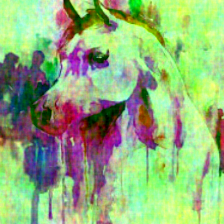

In [173]:
from PIL import Image

img1_abs = img_abs_list[144]
img1_pha = img_pha_list[144]
epsilon = np.random.randn(*sqrtvar_abs.shape)
img1_abs_new = epsilon * sqrtvar_abs + img1_abs
img1_abs_new = np.squeeze(img1_abs_new)

def reconstruct_img(img_abs, img_pha):
    img_abs = np.fft.ifftshift(img_abs, axes=(0, 1))

    img = img_abs * (np.e ** (1j * img_pha))
    img = np.real(np.fft.ifft2(img, axes=(0, 1)))
    img = np.uint8(np.clip(img, 0, 255))

    return img

img_new = reconstruct_img(img1_abs_new, img1_pha)

img_new = Image.fromarray(img_new)
img_new.show()

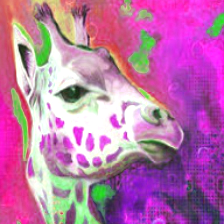

In [174]:
from PIL import Image

img1 = data_dict["x"][0]
img1 = Image.fromarray(img1)
img1.show()